## Load VCR datasets

In [9]:
from vcr.data.datasets.vcr import VCRDataset
from vcr.function.config import config, update_config
from vcr.data.build import make_dataloader
from vcr.data.transforms.build import build_transforms
from vcr.modules import *
import os
import sys
sys.path.append("/ibex/scratch/mag0a/Github/VL-BERT/")
from apex import amp
import torch
from vcr.data.build import make_dataloader
from vcr.data.collate_batch import BatchCollator
from common.trainer import to_cuda
import torch.nn.functional as F


In [10]:
update_config('/ibex/scratch/mag0a/Github/VL-BERT/cfgs/vcr/visualize.yaml')

/ibex/scratch/mag0a/Github/VL-BERT/vcr/function/config.py:176: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))


In [11]:
test_loader = make_dataloader(config,
                             mode='test',
                             distributed=False)
test_dataset = test_loader.dataset
test_database = test_dataset.database

Dataset kwargs:
{'basic_align': False,
 'mask_language_modeling': False,
 'mask_vl_modeling': False,
 'qa2r_aug': False,
 'qa2r_noq': False}
Dataset Basic Align: False
loading database from /ibex/scratch/mag0a/Github/VL-BERT/data/vcr/test.jsonl...
Done (t=3.46s)


In [12]:
from common.utils.load import smart_partial_load_model_state_dict

def generate_model(model_path= "/ibex/scratch/mag0a/Github/VL-BERT/experiments/vcr/contrastive_q2a/contrastive_q2a/vcr1images_train/vlbert_vcr_contrastive-best.model"):
    model = eval(config.MODULE)(config).cuda()
    
    pretrain_state_dict = torch.load(model_path, map_location=lambda storage, loc: storage)['state_dict']

    pretrain_state_dict_parsed = {}
    pretrain_prefix = 'module.'
    for k, v in pretrain_state_dict.items():
        no_match = True
        if k.startswith(pretrain_prefix):
            k = k[len(pretrain_prefix):]
            pretrain_state_dict_parsed[k] = v
            no_match = False        
        if no_match:
            pretrain_state_dict_parsed[k] = v

    pretrain_state_dict = pretrain_state_dict_parsed
    smart_partial_load_model_state_dict(model, pretrain_state_dict)
    del pretrain_state_dict
    del pretrain_state_dict_parsed

    # [model] = amp.initialize([model],
    #                          opt_level='O2',
    #                          keep_batchnorm_fp32=False)
    return model

In [13]:
model = generate_model()

/ibex/scratch/mag0a/Github/VL-BERT/common/backbone/resnet/resnet.py:214: UserWarning: miss keys: ['bn1.num_batches_tracked', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.bn2.num_batches_tracked', 'layer1.1.bn3.num_batches_tracked', 'layer1.2.bn1.num_batches_tracked', 'layer1.2.bn2.num_batches_tracked', 'layer1.2.bn3.num_batches_tracked', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.bn2.num_batches_tracked', 'layer2.0.bn3.num_batches_tracked', 'layer2.0.downsample.1.num_batches_tracked', 'layer2.1.bn1.num_batches_tracked', 'layer2.1.bn2.num_batches_tracked', 'layer2.1.bn3.num_batches_tracked', 'layer2.2.bn1.num_batches_tracked', 'layer2.2.bn2.num_batches_tracked', 'layer2.2.bn3.num_batches_tracked', 'layer2.3.bn1.num_batches_tracked', 'layer2.3.bn2.num_batches_tracked', 'layer2.3.bn3.num_batches_tracked', 'layer3.0.bn1.num_batches_tra

Warnings: Unexpected keys: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias'].
[Partial Load] partial load state dict of keys: dict_keys(['image_feature_extractor.backbone.conv1.weight', 'image_feature_extractor.backbone.bn1.weight', 'image_feature_extractor.backbone.bn1.bias', 'image_feature_extractor.backbone.bn1.running_mean', 'image_feature_extractor.backbone.bn1.running_var', 'image_feature_extractor.backbone.bn1.num_batches_tracked', 'image_feature_extractor.backbone.layer1.0.conv1.weight', 'image_feature_extractor.backbone.layer1.0.bn1.weight', 'image_feature_extractor.backbone.layer1.0.bn1.bias', 'image_feature_extractor.backbone.layer1.0.bn1.running_mean', 'image_feature_extractor.backbone.layer1.0.bn1.running_var', 'image_feature_extractor.

In [20]:
test_probs = []
test_ids = []
cur_id = 0
for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if config.DATASET.TASK == 'Q2A':
        output = model.inference_forward(*batch)
        probs = F.softmax(output['label_logits'].float(), dim=1)
        batch_size = probs.shape[0]
        test_probs.append(probs.float().detach().cpu())
        test_ids.append([test_database[cur_id + k]['annot_id'] for k in range(batch_size)])
        cur_id += batch_size
    elif config.DATASET.TASK == 'QA2R':
        conditioned_probs = []
        for a_id in range(4):
            q_index_in_batch = test_loader.dataset.data_names.index('question')
            q_align_mat_index_in_batch = test_loader.dataset.data_names.index('question_align_matrix')
            batch_ = [*batch]
            batch_[q_index_in_batch] = batch[q_index_in_batch][:, a_id, :, :]
            batch_[q_align_mat_index_in_batch] = batch[q_align_mat_index_in_batch][:, a_id, :, :]
            output = model.inference_forward(*batch_)
            probs = F.softmax(output['label_logits'].float(), dim=1)
            conditioned_probs.append(probs.float().detach().cpu())
        conditioned_probs = np.concatenate(conditioned_probs, axis=1)
        test_probs.append(conditioned_probs)
        test_ids.append([test_database[cur_id + k]['annot_id'] for k in range(conditioned_probs.shape[0])])
        cur_id += conditioned_probs.shape[0]
    
    if i > 200:
        break
        
test_probs = torch.cat(test_probs, dim=0)
true_labels = [None]*len(test_probs)

In [6]:
test_probs = []
true_labels = []
test_ids = []
cur_id = 0
for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if config.DATASET.TASK == 'Q2A':
        output, loss = model(*batch)
        probs = F.softmax(output['label_logits'].float(), dim=1)
        batch_size = probs.shape[0]
        test_probs.append(probs.float().detach().cpu())
        test_ids.append([test_database[cur_id + k]['annot_id'] for k in range(batch_size)])
        true_labels.append(output['label'])
        cur_id += batch_size
    
    if i > 2:
        break

true_labels = torch.cat(true_labels, dim=0)
test_probs = torch.cat(test_probs, dim=0)
print("{}\n{}".format(test_probs.argmax(1), true_labels))

tensor([1, 2, 2, 1, 1, 2, 1, 1, 2, 0, 2, 0, 2, 1, 3, 3])
tensor([1, 2, 2, 3, 2, 3, 1, 1, 2, 2, 3, 0, 2, 0, 3, 2], device='cuda:0')


## Visualize the images with the detector from vision_detectors.py models

In [18]:
import torch 
import torch.nn as nn
import torchvision
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json, copy


def filter_(str_list):
    copy_list = copy.deepcopy(str_list)
    for i, x in enumerate(str_list):
        if type(x) is list:
            copy_list[i] = '{}'.format(x[0])
    return copy_list

to_str = lambda x: ' '.join(filter_(x))

def visual_fig_with_box(database, predict_label, true_label=None):
    img_fn = database['img_fn']
    with open(database['metadata_fn'], 'r') as f:
        meta_fn = json.load(f)
    boxes = meta_fn['boxes']
    
    question = to_str(database['question'])
    
    answers = list(map(to_str, database['answer_choices']))
    rationales = list(map(to_str, database['rationale_choices']))
    str_labels = "Question: {} \n Answer Choices: {} \n Predict Label: {} ".format(question, answers, predict_label)
    if true_label is not None:
        str_labels += "True Label: {}".format(true_label)
#     print("Question: {}".format(question))
#     print("Answer: {}".format(answers))
#     # print("Rationale: {}".format(rationales))
#     print("Predict Label: ", predict_label)
    
    jpg_path = os.path.join("/ibex/scratch/mag0a/Github/visual-comet/data/vcr1images", img_fn)
    I = mpimg.imread(jpg_path)
    
    
    figure = plt.figure(figsize=(10,10))
    ax = figure.add_subplot(1,1, 1)
    
    ax.imshow(I)
    l = np.array(boxes)

    l[:,2]=l[:,2]-l[:,0]
    l[:,3]=l[:,3]-l[:,1]
    for j in range(len(l)):
        ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],linewidth=2,edgecolor='b',facecolor='none'))
    plt.xlabel(str_labels)

In [21]:
visual = lambda i: visual_fig_with_box(test_database[i], test_probs[i].argmax().item(), true_labels[i])
image = map(visual, range(200))

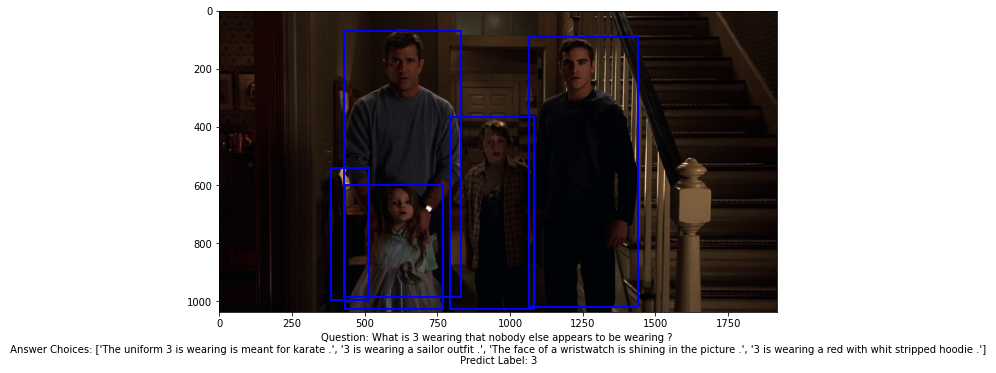

In [27]:
next(image)

In [25]:
test_probs[i]

tensor([0.9791, 0.0016, 0.0014, 0.0178])